In [ ]:
'''Example of use, and calculating errors
As a guide to how to successfully read in and interpret this file, we reproduce here code from "read_frame.pro" in the photoop IDL product:

;; 0. find filename of the frame file
framename = (sdss_name('frame', run, camcol, field, $
                       filter=filternum(filter), rerun=rerun))[0]+'.bz2'

;; 1. read in the FITS image from HDU0; the resulting image will be
;;    sky-subtracted as well as calibrated in nanomaggies/pixel
img= mrdfits(framename,0,hdr)
nrowc= (size(img,/dim))[1]

;; 2. read in sky, and interpolate to full image size; this returns a
;;    sky image the same size as the frame image, in units of counts
sky= mrdfits(framename,2)
simg= interpolate(sky.allsky, sky.xinterp, sky.yinterp, /grid)

;; 3. read in calibration, and expand to full image size; this returns
;;    a calibration image the same size as the frame image, in units of
;;    nanomaggies per count
calib= mrdfits(framename,1)
cimg= calib#replicate(1.,nrowc)
Steps (0) and (1) just read in the "image". Step (2) reads in the sky HDU, and bilinearly interpolates "allsky" onto a 2048x1489 sized array at the points on the grid defined by "xinterp" and "yinterp". Step (3) reads in the 2048-element vector defined the calibration-times-flat-field for each row, and expands it to a full-sized image.

If you have performed the above calculations, you can return the image to very close to the state it was in when input into the photometric pipeline, as follows:

dn= img/cimg+simg
These dn values are in the same units as the "data numbers" stored by the raw data files that come off the instrument. They are related to the detected number nelec of photo-electrons by:

nelec= dn*gain
The number of photo-electrons is the quantity that is statistically Poisson distributed. In addition, there are additional sources of noise from the read-noise and the noise in the dark current, which we will lump together here as the "dark variance." Thus, to calculate per-pixel uncertainties, you need the gain and darkVariance for the field in question. The darkVariance comes from the read noise and the noise in the dark current. In fact, these are nearly fixed as a function of camcol and filter (see the table below). You can retrieve the values from the field table in CAS (or the photoField file). With those values in hand the following yields the errors in DN:

dn_err= sqrt(dn/gain+darkVariance)
Statistical errors in the sky values are completely negligible. Finally, to get those errors into nanomaggies, you simply apply back the calibration:

img_err= dn_err*cimg
Finally, there are some areas of the image which are part of bleed trails, bad columns, and the like. If you require to track those in your analysis (e.g. weight them at zero) then you need to use the fpM files. Those files are in a special format, best read using the stand-alone atlas reader software. Use the utility called read_mask.

The gain and dark variance values are given below as a function of camcol and filter. In some cases the configuration was changed during the survey, and those cases are noted below. In detail, some chips had two amplifiers, and in those cases the values below are an intermediate value.'''

In [35]:
'''purpose: figure out whats going on with the sdss imaging data'''
'''what is the noise, what is the sky bg'''
import pyfits
import matplotlib.pyplot as plt
import heapq
import pyfits
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
import matplotlib.patches as patches
from astropy.io import fits
from scipy import interpolate

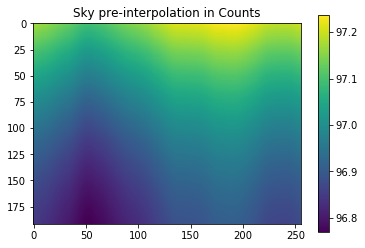

xnew inputs 0 1489 0 2048
(192, 256) (192, 256) (192, 256)
xold inputs 0 192 0 256
192 192 192


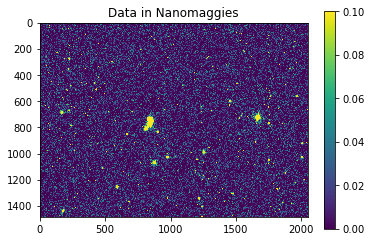

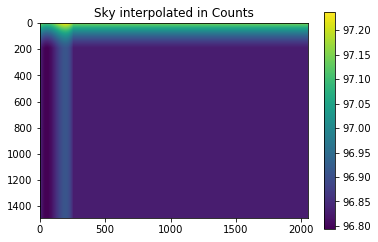

In [97]:
im=pyfits.open('frame-r-003918-3-0213.fits')


sky=im[2].data
sky_header=im[2].header

calib=im[1].data


plt.imshow(sky[0][0])
plt.title('Sky pre-interpolation in Counts')
plt.colorbar()
plt.show()

#>>> xnew, ynew = np.mgrid[-1:1:70j, -1:1:70j]
#>>> tck = interpolate.bisplrep(x, y, z, s=0)
#>>> znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)




xnew, ynew = np.mgrid[0:shape(im[0].data)[0] , 0:shape(im[0].data)[1] ]

print('xnew inputs',0, shape(im[0].data)[0], 0 , shape(im[0].data)[1])

xold, yold = np.mgrid[0:(shape(sky[0][0])[0]) , 0:(shape(sky[0][0])[1]) ]

print(shape(xold), shape(yold), shape(sky[0][0]))

print('xold inputs', 0 , (shape(sky[0][0])[0]) , 0 , (shape(sky[0][0])[1]) )

print(len(xold),len(yold),len(sky[0][0]))


tck = interpolate.bisplrep(xold,yold, sky[0][0])
snew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

#simg= interpolate(sky.allsky, sky['XINTERP'], sky['YINTERP'])




plt.imshow(im[0].data, vmin=0, vmax=0.1)
plt.title('Data in Nanomaggies')
plt.colorbar()
plt.show()

plt.imshow(snew)
plt.title('Sky interpolated in Counts')
plt.colorbar()
plt.show()

[[ 0.00516532  0.00516456  0.00516377 ...,  0.00514269  0.00514084
   0.00514153]]
(1, 2048)


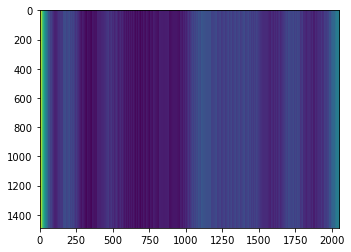

(1489, 2048)


In [124]:
print(np.array([im[1].data,]))

print(shape(np.array([im[1].data,])))

calibration=np.repeat(np.array([im[1].data,]), 1489,axis=0)

plt.imshow(calibration)
plt.show()

print(shape(calibration))

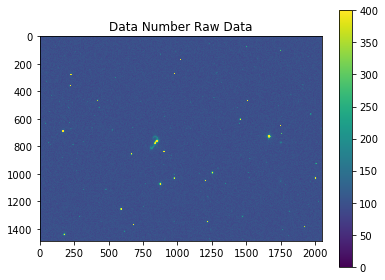

Mean DN for a background patch 96.9133547738
nelec [[ 438.97580815  462.55053474  429.51986989 ...,  490.6776516   448.18385386
   434.03738827]
 [ 462.55452704  434.23518452  438.93504663 ...,  419.8568849   457.61654083
   490.67154128]
 [ 481.42047273  471.97192447  438.92179003 ...,  467.0392263   438.71472552
   452.88626865]
 ..., 
 [ 481.43517439  434.20901848  420.05218855 ...,  462.32318818
   396.28350952  471.76562622]
 [ 495.60154829  438.9225388   429.48067861 ...,  462.33019058
   485.94539386  405.70490997]
 [ 467.26880049  471.97296053  471.96466793 ...,  443.44494089
   457.60733521  457.6072575 ]]


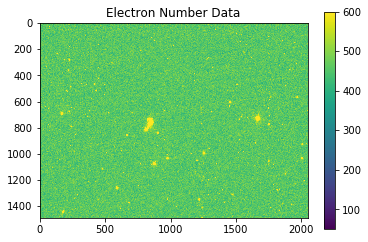

this is how you can do poisson noise


/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in true_divide


In [167]:
#
plt.clf()

img=im[0].data
cimg=calibration
simg=snew
dn= img/cimg+simg

plt.imshow(dn, vmin=0, vmax=400)
plt.title('Data Number Raw Data')
plt.colorbar()
plt.show()

print('Mean DN for a background patch', np.median(dn))
#These dn values are in the same units as the "data numbers" stored by the raw data files that come off the instrument. They are related to the detected number nelec of photo-electrons by:

gain=4.72#for camcol-3

nelec= dn*gain
print('nelec', nelec)

plt.imshow(nelec, vmin=50,vmax=600)
plt.title('Electron Number Data')
plt.colorbar()
plt.show()

print('this is how you can do poisson noise')


#dark variance is very very small :1.3225
# = read noise and dark current

darkVariance=1.3225

dn_err= np.sqrt(dn/gain+darkVariance)

img_err= dn_err*cimg
plt.clf()

fig=plt.figure()
ax1=fig.add_subplot(1,3,1)
im1=ax1.imshow(img, vmin=0, vmax=0.1)
plt.colorbar(im1)

ax2=fig.add_subplot(1,3,2)
im2=ax2.imshow(img_err ,vmin=0, vmax=0.05)
plt.colorbar(im2)

ax3=fig.add_subplot(1,3,3)
im3=ax3.imshow(img_err/img ,vmin=0, vmax=0.05)
plt.colorbar(im3)

plt.tight_layout()
savefig('percent_error_sdss.pdf')




/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


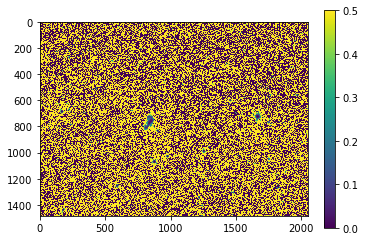

In [161]:
plt.clf()
plt.imshow(img_err/img, vmin=0,vmax=0.5)
plt.colorbar()
plt.show()


In [111]:
x = np.array([[1,2],])
print(x)
np.repeat(x, 3, axis=0)

[[1 2]]


array([[1, 2],
       [1, 2],
       [1, 2]])